# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [15]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.groupby('income').size()['>50K']

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data.groupby('income').size()['<=50K']

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)) * 100 / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

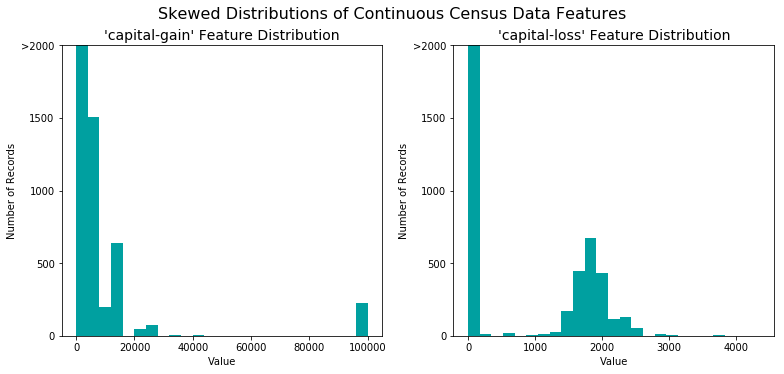

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

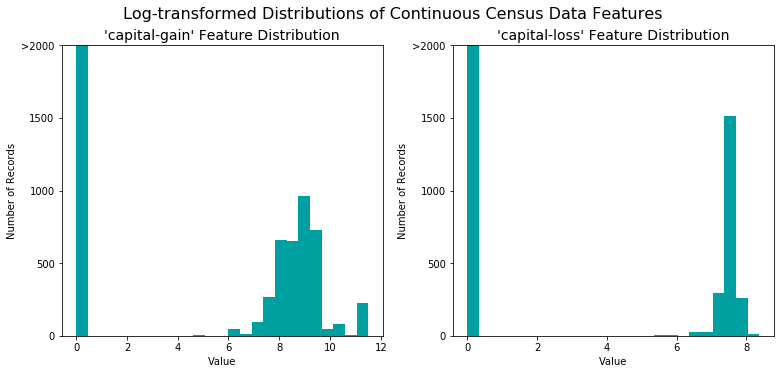

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform, drop_first=True)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.copy()
income[income == '<=50K'] = int(0)
income[income == '>50K'] = int(1)
income = income.astype(np.int32)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

95 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupa

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/Users/BennyBluebird/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
TP = float(np.sum(income)) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
                    # encoded to numerical values done in the data preprocessing step.
FP = float(income.count() - TP) # Specific to the naive case

TN = 0.0 # No predicted negatives in the naive case
FN = 0.0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + (0.5)**2) * ((precision * recall) / (((0.5)**2 * precision) + recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

### I. AdaBoost

**1.)** AdaBoost has found use in computer vision, where it was applied to identify basketball players in raw video stream (https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf). Although other approaches such as convolutional neural networks might achieve better accuracy on image classification, they do so at the expense of predictive speed. Because identification in this task needed to occur in real-time to support live game analysis, speed was the primary motivating factor for selecting AdaBoost. The authors believe that better performance could be achieved on pedestrian detection, where the persons of the interest don't move around and change positions as quickly.
    
    
**2.)** As an ensemble model, AdaBoost is less prone to overfitting than models that operate in isolation such as decision trees or neural networks. This model works great out-of-the-box and doesn't require tuning lots of hyperparameters to get strong performance. Furthermore, it is fast and scales well to large datasets of a variety of data formats - tabular, image, etc. (https://arxiv.org/abs/1312.6086). AdaBoost works best for classification problems when datasets contain minimal outliers and in general when decision boundaries around classes aren't too fuzzy.

    
**3.)** The main weakness of AdaBoost involves its core training mechanism when faced with noisy data or outliers (https://en.wikipedia.org/wiki/AdaBoost: "Statistical Understanding of Boosting"). Due to its focus on classifying problematic samples, it could try too hard to classify outliers when it should just ignore them. For this, it helps AdaBoost if outliers are manually removed during data preprocessing. An additional weakness is that it rarely produces state-of-the-art performance on supervised learning problems. AdaBoost is generally selected for its simplicity, intepretability, speed, and ability to grant superior performance over base models such as decision trees, however if maximum accuracy is sought at all costs, then it may not be the best choice of algorithm. Neural networks or gradient boosting are superior choices in such cases.

    
**4.)** Given the importance of precision over recall in this problem, AdaBoost is a good candidate algorithm as it iteratively improves itself over training epochs by placing higher weight on difficult to classify examples in a dataset. In the event that there are several troublesome false positives in the dataset, AdaBoost's focus on continuous improvement could work well to reduce these - thus increasing precision in the process. AdaBoost's speed in training and predicting could be an asset as well so when new demographic data was received, the non-profit could promptly act on it by reaching out to targeted donors before its competitors.
    
    
### II. Random Forest

**1.)** The remote sensing community has benefited greatly from utilizing random forests in its classification tasks (https://www.sciencedirect.com/science/article/pii/S0924271616000265). In remote sensing, data arrives through a variety of sensors, which results high dimensional datasets. Random forest helps to address the curse of dimensionality by deploying many weak decision trees that focus on classifying samples using a subset of the features, so each tree in a sense is encouraged to specialize on a certain aspect of the data. Combining them results in a robust classifier that can both make highly accurate predictions on out-of-sample data.


**2.)** A strength of random forest is that as the trees subsample the feature space during training, the features that help discrimate classes the best are discovered and given a heavier weight in the final ensemble (http://scikit-learn.org/stable/modules/ensemble.html#random-forests). In other words, feature selection is a core part of how the model makes predictions - an added bonus that aids interpretability. This grants robustness against multicolinearity (redudant features). Since each decision tree is trained on a subset of samples (bootstrap sample) as well, no tree sees the entire dataset, so bias (underfitting) is favored over variance (overfitting) on the level of individual trees. When the decision trees are combined, their net predictive capacity is powerful, yet retains resistance to overfitting. Random forest works well with data that has balanced classes, i.e. classes represented in roughly equal proportions.


**3.)** A weakness of random forest is being sensitive to sampling design (https://www.sciencedirect.com/science/article/pii/S0924271616000265), therefore to build a strong model, its important to gather a sample of data that is highly representative its population. Since random forest applies multiple decision trees to different subsets of training data, it doesn't work well on datasets with high class imbalance, such as a situation where one 90% of samples represent one class, with 10% left to another. In such a case, random forest isn't able to take advantage of subsampling the input space, since most of the trees will end up redundantly modeling the overrepresented class(es).


**4.)** Given that the transformed data has 95 features, random forest is a good candidate in that it can successfully a handle such high-dimesionality through subsampling the feature space. In computer vision or natural language processing tasks, 95 features isn't all that many, however I'd argue that it is quite a few in a problem with tabular data such as this. Decision tree based models in general excel at tabular data tasks, so combining their base strength with the benifits of bagging makes random forest a suitable model for this problem.

### III. Gradient Boosting

\**Although gradient boosting can be applied on any weak learner, the description below assumes it is being applied to shallow regression trees, which are nearly always used in practice. Scikit-learn also supports this implementation of gradient boosting.*

**1.)** Researchers at Yahoo revealed that the company's search engine used gradient boosting to optimize results (https://web.archive.org/web/20100807162855/http://www.stat.rutgers.edu/~tzhang/papers/it08-ranking.pdf). The central problem their product faced was organizing search results by rank, so that more useful search results would be organized at the top of a given query. Applying this algorithm helped the search engine boost its DCG (discounted cumulative gain), which measures the relevance of documents at the top of a ranked list.


**2.)** The primary strength of gradient boosting is its performance. XGBoost - an optimized implementation of gradient boosted trees - frequently shows up in winning models in Kaggle competitions. This list contains 13 examples of XGBoost being used in the top 3 submissions of various competitions: https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions.


**3.)** The main drawback of gradient boosting is difficulties with scalability due to training time (http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting). Since it "boosts" the performance of a succession weaker learner through iteration, training time can take considerably longer than random forest, which can train weak learners in parallel. Another downside is its complexity. There are three hyperparameters that require tuning - learning rate, max tree depth, and number of estimators (trees). Adding too many estimators can lead to overfitting on out-of-sample data, so care must be taken to find the right balance between training and test performance. Lastly, of the three models, gradient boosting is perhaps the most difficult to interpret and explain to a non-technical audience, who may struggle to grasp its core optimization techinque - gradient descent.


**4.)** As seen above, gradient boosting is known for generating state-of-the-art performance on classification problems involving tabular datasets, such as the one in this project. Since this non-profit is likely constrained by money and time when reaching out to donors, it is paramount to go for the maximum precision in classifying income levels. Morever, as an ensemble model that uses decision trees as its weak learners, it can operate directly mixed data types, including categorical and missing data, without notably impacting performance or requiring complicated preprocessing steps. Although we applied preprocessing in this project, it's not clear that the non-profit users, when handed the model, would have the ability to understand and implement these steps themselves. In such case, providing a model that can be applied directly to raw data with minimal intermediate transformation steps is of great benefit.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


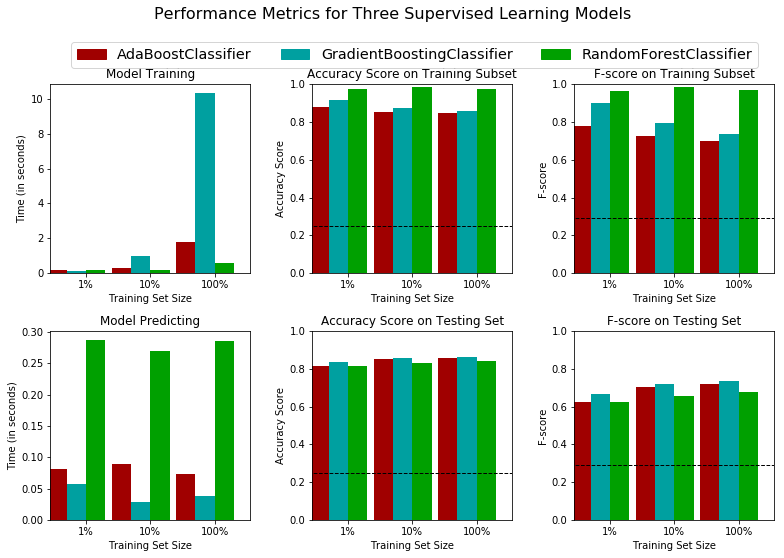

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier


# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=42) 
clf_B = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_C = GradientBoostingClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

- Gradient Boosting is the most appropriate model for this task for reasons of both predictive capacity and speed. Although all three models are examples of ensemble learning, gradient boosting edges out AdaBoost and Random Forest by a narrow margin for all training set sizes. This means it is the superior model even with a small amount of training data, although providing more data can certainly improve its performance. With a dataset of this size and type, its important to choose a model as well that is robust against outliers. Since this dataset consist of census metrics, outliers could have come from a variety of sources. For one, data in such a survey was hand-collected by humans who could have made recording mistakes. In addition, participants in the census could have lied about or exaggerated certain metrics, including household income - the differentiating factor in this project. If an algorithm that is sensitive to outliers such as AdaBoost was employed, then it would overwork itself or overfit trying to figure out how to classify these individual outliers when in fact they aren't relevant to the core problem at all. Gradient boosting on the other hand tries to get the most bang for its buck through minimizing a global loss function, therefore it wouldn't use its finite number of estimators to overfit on outliers that grant minimal performance increases overall.


- In production, the training of the model is typically a one-time or scheduled nightly event that occurs on the server side, therefore whether it takes 2 hours or 2 seconds doesn't really make much of a difference. On the client side, where the model is actually being used, prediction speed is what matters. Gradient boosting excels on this metric, giving users the ability to make thousands of predictions in under a second. In an production environment where a model is continuously being updated with batches of streaming data, random forest would be the better choice because its training process can be parallelized across multiple cores, whereas gradient boosting cannot due to its sequential nature of its training process.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

- Gradient boosting isn't a model in itself, but instead a member of the boosting class of ensemble methods, which itself is a subclass of machine learning methods in general. Ensemble learning works by combining the insight of multiple weak learners, versus trusting one strong learner (https://en.wikipedia.org/wiki/Boosting_(machine_learning)). It's akin to trusting the wisdom of the crowd over that of an expert. Boosting is a special type of ensemble learning that involves training weak models one after the other (sequentially). The central idea is that if a weak learner can be shown to learn anything about a problem in that it performs better than random guessing, than it can be "boosted" to a higher level accuracy through iterative improvement. 



- Although gradient boosting can be applied to any ensemble of weak learners, in the vast majority of implementations the learners of choice are decision tree stumps, hence the common name "gradient boosted trees" (http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting). These are weak decision trees only two layers deep, or that only involve a single split of a dataset. Whereas traditional decision trees work by maximizing information gain at a given split, gradient boosted trees deploys a series of stumps that, that when chained together, minimize a loss function such as mean squared error. Each tree is fit to the error (true minus predicted) of the previous one, which is added to the previous prediction. One can imagine two weather forecasters, the first who specializes in estimating the temperature tomorrow, and the second who specializes in estimating how far the first one will be off from the true temperature. The first one forecasts 77 degrees, and the second one, using his notes from past forecasts, is able to estimate that on average the first forecaster estimates 7 degrees too high, or with an error of -7. An outsider overseeing the process in turn makes a "super forecast" by adding 77 and -7 and getting 70 degrees, which takes into account information from both forecasters. Although simplified considerably, this is how gradient boosting works in a nutshell. The equivalent of this example in gradient boosting would be a ensemble of two decision tree stumps, however since compute power is cheap - in practice 100 or more estimators are often involved in classification tasks using this algorithm.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'learning_rate': [0.001,0.01], 'max_depth': [2,4,6], 'n_estimators': [100,200]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_obj.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta=0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5))

/Users/BennyBluebird/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Unoptimized model
------
Accuracy score on testing data: 0.8628
F-score on testing data: 0.7377

Optimized Model
------
Final accuracy score on the testing data: 0.8607
Final F-score on the testing data: 0.7403


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:
|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.8628        |      0.8607     |
| F-score        |     0.7377        |      0.7403     |


**Answer: **

- The optimized model's accuracy and F-score on the testing data are 0.8607 and 0.7403 respectively - slightly superior to the unoptimized model, but not enough to rule out overfitting or random chance. It seems that performance is bounded mostly by the nature of the data and the constraints of algorithm itself, not the hyperparameters of the model. Despite this, the scores compare much more favorably with the naive results from earlier. This indicates that there are indeed discrimative features in the dataset and that the model is able to extract some of them, just not enough to grant truly outstanding performance at this point. Collecting more data or further engineering features could perhaps address this shortcoming.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

**1.)** Capital gain: Only this and capital loss give direct insight into an individual's current financial status. The other features have an indirect relationship with one's personal finances. Accruing capital gains indicates that one has active investments in stocks, bonds, real estate, etc., and typically these activities are reserved for high-income individuals, so this should be a very strong predictor of income level.


**2.)** Education: A classic example in econometrics demonstrates the relationship between education and income. Common wisdom also suggests that higher education levels lead to higher incomes. I believe education level is more important in this regard than number of years completed because degree attainment is ultimately what matters in the job market. On an application, "Bachelors" is seen as significantly superior to "Some-college", even though the difference between the two can come down to a year of study or less. The reason I rank this second is because education is an indirect indicator of income that is not always reliable on the individual level.


**3.)** Age: Whereas education is the primary factor that influences employablity when one is young, experience gradually takes over with time. The older someone is, the more time they have had to build work experience and obtain a valuable position that grants them a higher income. As with education, age can help us predict income indirectly, but there's nothing about age itself that is related to personal finances.


**4.)** Occupation: There are several categories in the this feature that should be associated with higher income, such as "Exec-managerial" and "Prof-speciality". On the other hand, there are those that should be associated with lower income, such as "Handlers-cleaners" and "Priv-house-serv". While these examples sit on the extremes, most categories here are somewhere in the middle such as "Sales", "Farming-fishing", and "Transport-moving"; therefore, it's difficult to say from occupation alone whether or not one earns more than $50,000.


**5.)** Native Country: The dataset includes citizens from a mixture of developed countries (US, Japan, Germany), developing countries (China, India, Vietnam), and undeveloped countries (Laos, Haiti, Cambodia). In general, people in developed countries make significantly more than those in undeveloped countries, so this should be a good predictor of one's income level. Within particular countries however, income disparities can be quite large. There are undoubtedly many poor people in the US and many rich people in Cambodia, so as with occupation, this feature by itself can be a noisy predictor.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

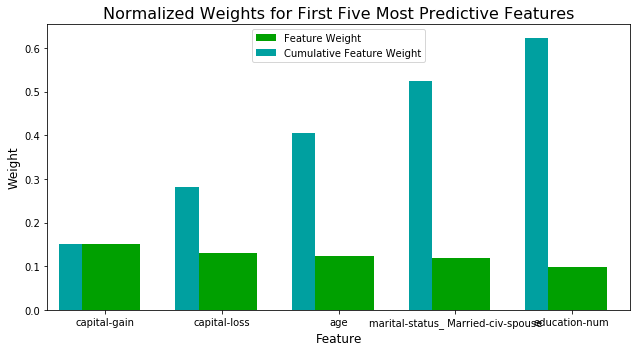

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'
# Already using GradientBoostingClassifier, which has feature_importances_ attribute

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
# This is the default GradientBoostingClassifier, already trained on (X_train, y_train)
model = grid_obj.estimator 

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

- I had the right idea for what makes some features relevant, but overlooked certain aspects of the problem. Capital gains was indeed the best predictor of income level. My reasoning was that capital gains indicates investments, which in turn is associated with high income level. This was confirmed by the above visualization, with capital gains ranking as the most relevant feature. Age was highly relevant as expected, as it is the best feature that indirectly predicts personal finances. I overlooked marital status, but believe now that its relevance can be attributed to the relationship between family stability and income. Education ended up ranking last in the top five, behind age and marital status, which lends credence to the idea that experience trumps education over the long term. The median age in the dataset is 37, so most citizens sampled were well-progressed in their careers at the time of this census.


- Below, I've provided some optional visualizations to help readers better grasp the importance of certain features. In the first figure, we can see that among citizens with capital gains, nearly twice as many are high income earners, which would explain why this feature is useful in separating the two groups. Why capital loss is important is not so clear however, as it appears that when this feature is present, the probability distribution is about 50/50 that the citizen earns more than 50,000 or not. The age distribution histograms clearly depicts the relationship between age and income level. Citizens earning more than 50,000 are likely to be older as predicted. Likewise, the education distribution charts show that citizens earning more than 50,0000 are disproportionality represented in the group that attained 11 to 15 years of education (higher education).

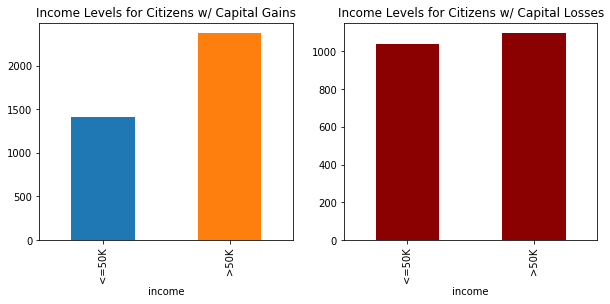

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)

data[data['capital-gain'] != 0.0].groupby('income').size().plot(
    ax=axes[0], kind='bar', title='Income Levels for Citizens w/ Capital Gains')

data[data['capital-loss'] != 0.0].groupby('income').size().plot(
    ax=axes[1], kind='bar', title='Income Levels for Citizens w/ Capital Losses', color='#8b0000')

plt.show()

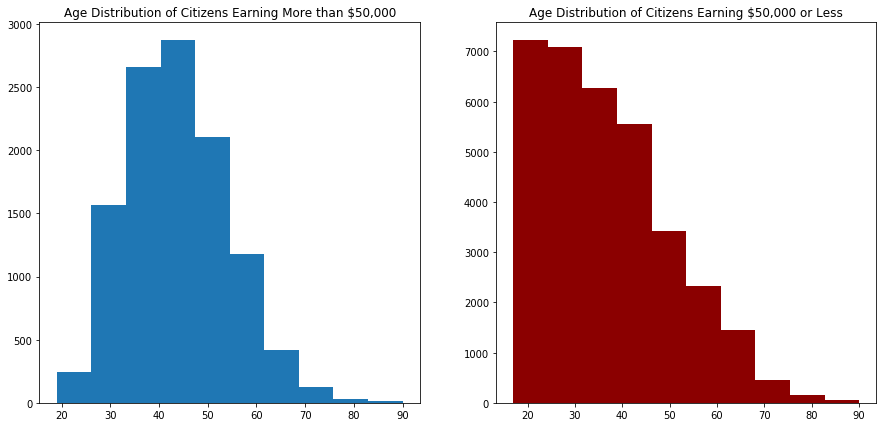

In [17]:
fig = plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.hist(data[data['income'] == '>50K']['age'])
plt.title('Age Distribution of Citizens Earning More than $50,000')
plt.subplot(1,2,2)
plt.hist(data[data['income'] != '>50K']['age'], color='#8b0000')
plt.title('Age Distribution of Citizens Earning $50,000 or Less')
plt.show()

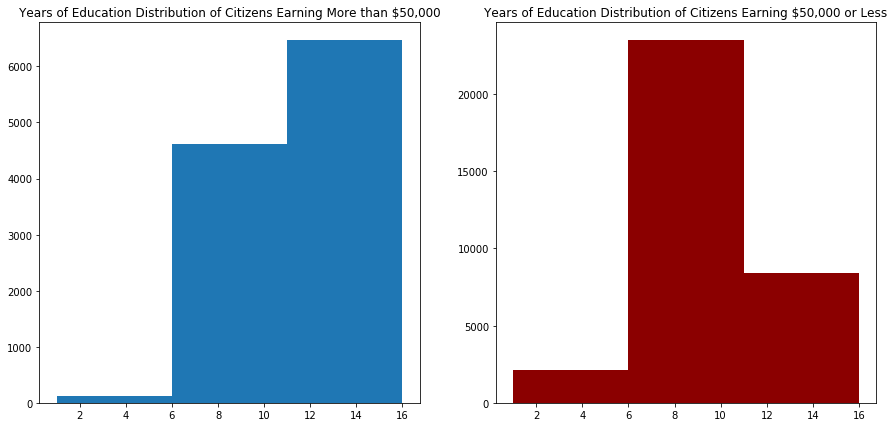

In [18]:
fig = plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
# Bin count of three was chosen to roughly represent primary, secondary, and higher levels of education
plt.hist(data[data['income'] == '>50K']['education-num'], bins=3)
plt.title('Years of Education Distribution of Citizens Earning More than $50,000')
plt.subplot(1,2,2)
plt.hist(data[data['income'] != '>50K']['education-num'], color='#8b0000', bins=3)
plt.title('Years of Education Distribution of Citizens Earning $50,000 or Less')
plt.show()

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8607
F-score on testing data: 0.7403

Final Model trained on reduced data
------
Accuracy on testing data: 0.8553
F-score on testing data: 0.7297


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

- Reducing the feature space here only resulted in a the minor performance drop for both accuracy and F-Score, all else held equal. This indicates that feature selection / engineering is a task worthy of more effort on this problem. Perhaps, this dataset could be trimmed to these five features, and then additional - more discrimative - features could be sought and added to further improve the model's predictive capacity. 


- Considering this, and that training time is one of the main downsides of gradient boosting, training using with a reduced feature set would certainly be beneficial for the non-profit users of the model. Doing so would especially prove useful when searching for optimal hyperparameters using grid search. This assumes that grid search results are highly correlated on the original feature set and the reduced set -  which is likely but not certain. Further testing would support or negate such a hypothesis. The grid seach step in this project took about 30 minutes, which would only get longer with more data. At such a rate, training time could begin to get unacceptably long for certain users that demand rapid insight. Since gradient boosting involves a sequential algorithm, the model itself unfortunately doesn't afford ways to reduce training time directly, so looking to the data for performance increases like this is a wise and clever move indeed.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.